In [288]:
#Imports

# standard library
import sys
import os 
import time
import re
import glob
import pickle 
import operator 

# numpy, scipy, etc
import numpy as np
import mkl
from scipy import ndimage as ndi
from scipy.stats import norm
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import seaborn as sns

# for networks
import networkx as nx

# required bastet, MIDAS, and pactolus specific modules:
def isneeded(x):
    if x not in sys.path:
        sys.path.append(x)

isneeded('/Users/curt/bastet/')
isneeded('/Users/curt/meta-iq/pactolus/pactolus/')
isneeded('/Users/curt/meta-iq/midas_lbl/')

# pactolus
from score_spectra import score_spectra_pairwise, sparse_uncertain_dot, calc_lambda, calc_dot_matrix


# timing and profiling
import timeit
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
with open('Actino_C18_Pos.pickle', 'r+') as io:
    my_data = pickle.load(io)

In [3]:
my_data.keys()

['rt',
 'scan',
 'collision_energy',
 'precursor_intensity',
 'file',
 'precursor_mz']

In [4]:
len(my_data['scan'])

651072

In [5]:
# how many unique scans?

len(np.unique(my_data['precursor_mz']))


62085

In [6]:
np.min(my_data['precursor_mz'])

70.010002

In [7]:
np.max(my_data['precursor_mz'])

1048.7751

In [11]:
sorted_unique_precursors = np.unique(my_data['precursor_mz'])

In [12]:
sorted_unique_precursors[0:10]

array([ 70.01000214,  70.01332855,  70.01337433,  70.01338196,
        70.01339722,  70.01340485,  70.01343536,  70.01344299,
        70.01345062,  70.01346588], dtype=float32)

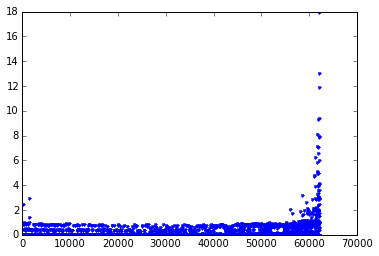

In [13]:
plt.plot(np.diff(sorted_unique_precursors), '.')

<Container object of 979 artists>

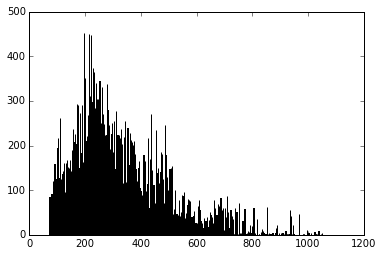

In [14]:
bin_edges = np.arange(70, 1050, 1)

binned_precursor_mzs, _ = np.histogram(sorted_unique_precursors, bins=bin_edges)

bin_width = np.diff(bin_edges).mean()

bin_centers = bin_edges[:-1] + bin_width/2

plt.bar(bin_centers, binned_precursor_mzs)

651072


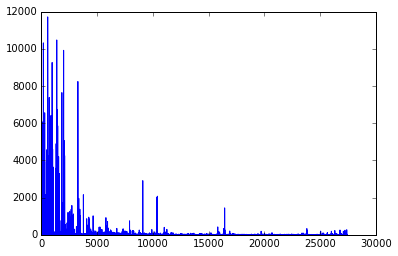

In [17]:
# All precursor masses that round to the same value should be treated as identical
rounded_uniques, index_to_uniques, counts = np.unique(np.around(my_data['precursor_mz'], 
                                                                decimals = 4), 
                                                      return_inverse=True,
                                                      return_counts = True)

index_to_sort = index_to_uniques.argsort()

# TODO: implement a function which is like around() 
#       but puts out a tuple of possible "true" precursor mzs to allow for neutral losses

print len(index_to_uniques)

plt.plot(counts)

In [18]:
len(counts)

27437

In [19]:
index_to_uniques[index_to_sort][0:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [20]:
# group scans by their rounded mass value

my_grouped_data = {}

for field in my_data:
    my_grouped_data[field] = [my_data[field][el] for el in index_to_sort]
    
my_grouped_data['group'] = index_to_uniques[index_to_sort]

In [23]:
# example entries my my_grouped_data

my_grouped_data['precursor_mz'][0:10], my_grouped_data['group'][0:10]

my_grouped_data['precursor_mz'][2000:2010], my_grouped_data['group'][2000:2010]
    

([array([ 72.08000183], dtype=float32),
  array([ 72.08000183], dtype=float32),
  array([ 72.08000183], dtype=float32),
  array([ 72.08000183], dtype=float32),
  array([ 72.08000183], dtype=float32),
  array([ 72.08000183], dtype=float32),
  array([ 72.08000183], dtype=float32),
  array([ 72.08000183], dtype=float32),
  array([ 72.08000183], dtype=float32),
  array([ 72.08000183], dtype=float32)],
 array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20]))

In [82]:
# convert to list of Scan objects

class MS2_Scan(object):
    """Python class for holding a single tandem mass spectrum"""
    def __init__(self, params):
        """
        :param params: dict that must contain these key, value pairs:
                            precursor_mz: float
                            collision_energy: float
                            precursor_intensity: float
                            scan_data: ndarray of shape (n_peaks, 2) with columnz m/z and intensity
                            filename: string
                        option key, value pair:
                            group: int or string
        """
        
        # required parameters
        self.rt = params['rt']
        self.precursor_mz = params['precursor_mz']
        self.collision_energy = params['collision_energy']
        self.precursor_intensity = params['precursor_intensity']
        self.scan_data = params['scan_data']
        self.filename = params['filename']
        
        # optional parameters
        if 'group' in params.keys():
            self.group = params['group']
        else:
            self.group = None
        return

class MS2_ScanSet(list):
    """Python class for holding groups of MS2 scans."""
    def __init__(self, list_of_MS2_Scans):
        
        # record the scans
        self.scans = list_of_MS2_Scans
        
        # record the groups as a dictionary keyed on group names, with values as lists of indices
        self.groups = {}
        all_groups = np.unique([scan.group for scan in self.scans])
        for group_name in all_groups:
            self.groups[group_name] = np.where(scan.group == group_name for scan in self.scans)[0]
        return
    
    def calc_dot_matrix_of_groups(self, params=None, max_num_scans=500):
        self.dot_matrix_by_groups = {}
        if params is None:
            params = {
                      'mass_tol': 0.001,
                      'neutral_losses': [0],
                      'noise_cutoff': 1000,
                      'normalize': 2,
                      }
        for group_name in self.groups:
            raw_group_scans = [scan.scan_data for scan in self.scans if scan.group == group_name]
            if len(raw_group_scans) > max_num_scans:
                print 'Too many scans (%s) in group %s for calculation; skipping...' % (len(raw_group_scans), group_name)
                continue
            print 'Finding similarity matrix for group %s of %s scans.' % (group_name, len(raw_group_scans))
            self.dot_matrix_by_groups[group_name] = calc_dot_matrix(raw_group_scans, params)
        return
            
        


def convert_dict_of_lists_to_list_of_scans(my_dict):
    scan_list = []
    
    for idx, _ in enumerate(my_dict['file']):
        params = {'rt': my_dict['rt'][idx],
                  'precursor_mz': my_dict['precursor_mz'][idx],
                  'precursor_intensity': my_dict['precursor_intensity'][idx],
                  'collision_energy': my_dict['collision_energy'][idx],
                  'scan_data': my_dict['scan'][idx],
                  'filename': my_dict['file'][idx],
                  }
        
        if 'group' in my_dict.keys():
            params['group'] = my_dict['group'][idx]
        scan_list.append(MS2_Scan(params))
    return scan_list


In [151]:
# load the data from a pickle file if it is there, otherwise do the calculation and save it
try:
    with open('dumped_pickle_data.pkl', 'r+') as io:
        my_scan_set = pickle.load(io)
        print 'Found pickle file; loading data.'
except IOError:
    print 'Could not find pickle file, repeating calculation of group proximity matrices.'
    my_scan_list = convert_dict_of_lists_to_list_of_scans(my_grouped_data)
    my_scan_set = MS2_ScanSet(my_scan_list)

    # do dot matrixing
    my_scan_set.calc_dot_matrix_of_groups()
    
    # save results
    with open('dumped_pickle_data.pkl', 'w') as io:
        pickle.dump(my_scan_set, io)
    


Found pickle file; loading data.


In [152]:
len(my_scan_set.scans)

651072

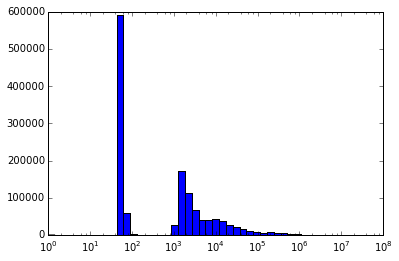

In [153]:
# Look at distribution of all MS2 peak intensities in all scans to decide noise cutoff

all_ints = np.array([my_scan_list[idx].scan_data[:, 1] for idx in xrange(len(my_scan_list))]).flatten()

plt.hist(all_ints, bins = np.logspace(0, 8))

plt.gca().set_xscale('log')

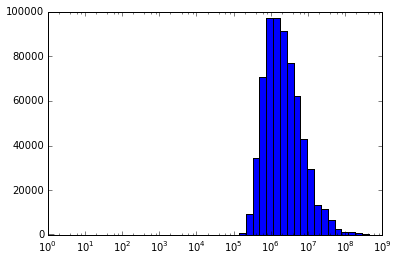

In [154]:
# Look at distribution of all parent peak intensities in all scans to decide noise cutoff

all_ints = np.array([my_scan_list[idx].precursor_intensity for idx in xrange(len(my_scan_list))])

plt.hist(all_ints, bins = np.logspace(0, 9))

plt.gca().set_xscale('log')

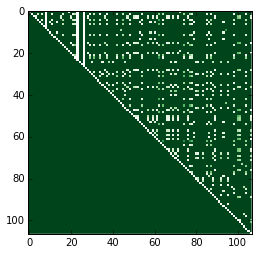

In [155]:
# do some clustering

plt.imshow(my_scan_set.dot_matrix_by_groups[0], 
           cmap=cm.Greens_r,
           interpolation='none',
           )

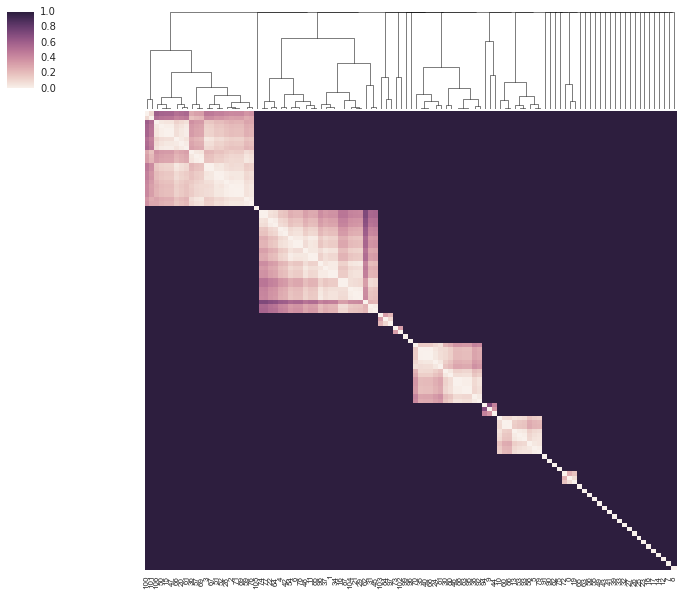

In [338]:



def make_distance_matrix_clustergram(prox_mat):
    # convert upper-triangular proximity matrix to a full-square distance matrix
    upper_trig = prox_mat.copy()
    lower_trig = upper_trig.T.copy()
    diag_idxs = np.diag_indices_from(upper_trig)
    lower_trig[diag_idxs] = 0
    proximity_mat = upper_trig + lower_trig

    # get rid of NaNs
    proximity_mat[np.isnan(proximity_mat)] = 0
    
    # ensure diagonal of distance_matrix is zero
    proximity_mat[np.diag_indices_from(proximity_mat)] = 1
    
    # ensure full proximity matrix is symmetrc
    assert np.allclose(proximity_mat, proximity_mat.T)
    
    # clustering require distances, not proximities
    distance_mat = 1 - proximity_mat
    
    # 
    D = ssd.squareform(distance_mat)
    Y = sch.linkage(D, method='complete')

    g = sns.clustermap(data=distance_mat,
                       row_linkage=Y,
                       col_linkage=Y,
                       figsize=(12, 10),
                       yticklabels=False,
                       )
    my_labels = [el.get_text() for el in g.ax_heatmap.get_xticklabels()]
    g.ax_heatmap.set_xticklabels(my_labels, size=8)
    g.ax_row_dendrogram.set_visible(False)
    return g

make_distance_matrix_clustergram(my_scan_set.dot_matrix_by_groups[0])

In [268]:
my_labels = [el.get_text() for el in g.ax_heatmap.get_xticklabels()]
print my_labels

[u'100', u'101', u'106', u'50', u'15', u'47', u'66', u'20', u'61', u'36', u'57', u'69', u'3', u'67', u'51', u'52', u'28', u'2', u'71', u'89', u'59', u'76', u'105', u'74', u'77', u'22', u'64', u'4', u'42', u'54', u'6', u'78', u'48', u'11', u'85', u'98', u'37', u'1', u'34', u'16', u'87', u'104', u'21', u'29', u'62', u'31', u'45', u'103', u'84', u'97', u'73', u'102', u'99', u'96', u'70', u'35', u'40', u'68', u'24', u'81', u'30', u'80', u'46', u'88', u'83', u'95', u'38', u'92', u'94', u'9', u'44', u'10', u'60', u'86', u'13', u'53', u'93', u'58', u'5', u'79', u'91', u'90', u'82', u'75', u'72', u'0', u'19', u'65', u'63', u'56', u'55', u'49', u'43', u'41', u'39', u'33', u'32', u'27', u'26', u'25', u'23', u'18', u'17', u'14', u'12', u'7', u'8']


In [223]:
print g.dendrogram_row.reordered_ind

[100, 101, 106, 50, 15, 47, 66, 20, 61, 36, 57, 69, 3, 67, 51, 52, 28, 2, 71, 89, 59, 76, 105, 74, 77, 22, 64, 4, 42, 54, 6, 78, 48, 11, 85, 98, 37, 1, 34, 16, 87, 104, 21, 29, 62, 31, 45, 103, 84, 97, 73, 102, 99, 96, 70, 35, 40, 68, 24, 81, 30, 80, 46, 88, 83, 95, 38, 92, 94, 9, 44, 10, 60, 86, 13, 53, 93, 58, 5, 79, 91, 90, 82, 75, 72, 0, 19, 65, 63, 56, 55, 49, 43, 41, 39, 33, 32, 27, 26, 25, 23, 18, 17, 14, 12, 7, 8]


In [226]:
all_0_data = [scan for scan in my_scan_set.scans if scan.group==0]

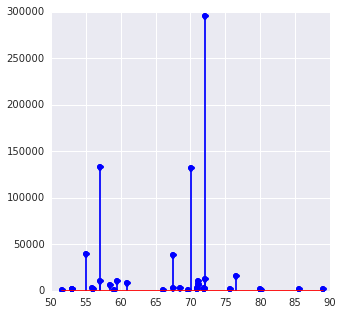

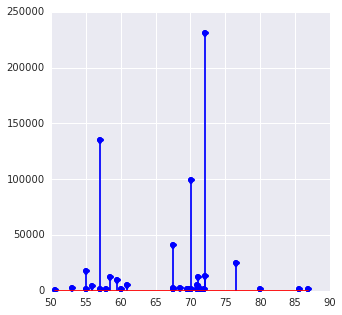

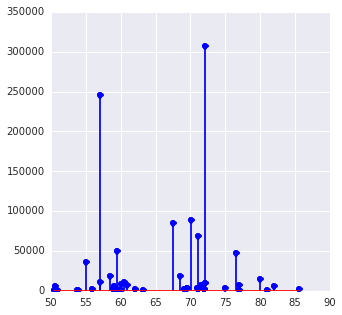

In [235]:
def plot_spectrum(scan):
    plt.figure(figsize=(5, 5))
    plt.stem(scan[:, 0], scan[:, 1])
    plt.show()
    
plot_spectrum(all_0_data[100].scan_data[0])
plot_spectrum(all_0_data[101].scan_data[0])
plot_spectrum(all_0_data[102].scan_data[0])

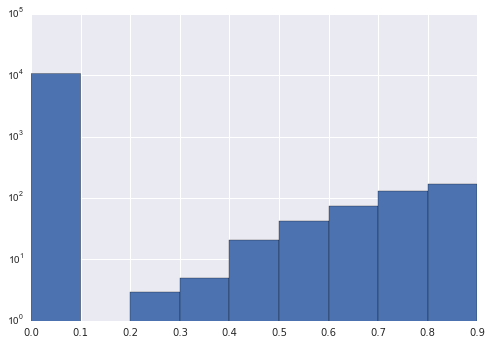

In [285]:
# determine where to threshold our distance metric in order to make links

plt.hist(my_scan_set.dot_matrix_by_groups[0].flatten(), bins = np.arange(0, 1, 0.1))
plt.gca().set_yscale('log')

In [289]:
# draw network from heatmap

dot_cutoff = 0.5

proximity_matrix = my_scan_set.dot_matrix_by_groups[0].copy()

adjacency_matrix = proximity_matrix > dot_cutoff

group_0_network = nx.to_networkx_graph(adjacency_matrix)

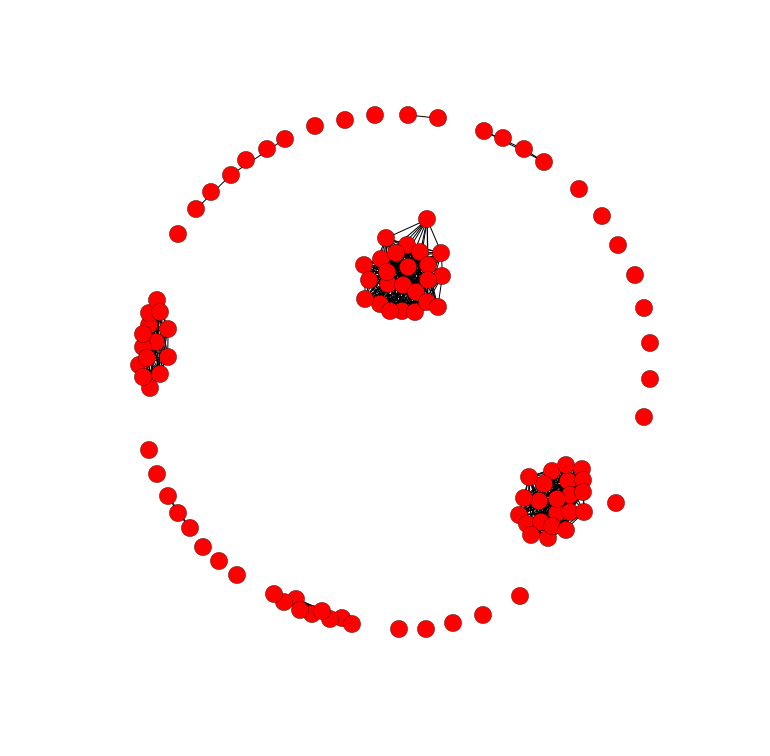

In [325]:
from math import sqrt

plt.figure(figsize=(10, 10))


layout = nx.spring_layout(group_0_network)
nx.draw(group_0_network, pos=layout)

In [313]:
group_0_network.number_of_nodes

<bound method Graph.number_of_nodes of <networkx.classes.graph.Graph object at 0x136ba8fd0>>

In [335]:
from collections import Counter

group_counter = Counter([scan.group for scan in my_scan_set.scans])

less_than_500 = group_counter.copy()
for group in group_counter:
    if group_counter[group] > 500:
        less_than_500.pop(group)
        
less_than_500.most_common()
    

[(224, 498),
 (5795, 498),
 (783, 491),
 (5797, 489),
 (5794, 488),
 (1374, 486),
 (3463, 486),
 (308, 481),
 (5807, 473),
 (191, 471),
 (4291, 458),
 (5799, 456),
 (192, 455),
 (6, 452),
 (1359, 451),
 (1379, 450),
 (605, 448),
 (3158, 443),
 (117, 441),
 (2664, 441),
 (5802, 439),
 (5924, 439),
 (507, 435),
 (1334, 430),
 (309, 427),
 (4335, 426),
 (15821, 424),
 (5265, 421),
 (544, 420),
 (806, 419),
 (43, 412),
 (5189, 412),
 (2658, 410),
 (5801, 409),
 (3276, 405),
 (632, 404),
 (4284, 404),
 (11026, 401),
 (395, 397),
 (3356, 395),
 (4292, 391),
 (2784, 379),
 (1349, 376),
 (1331, 370),
 (1906, 370),
 (6004, 362),
 (2414, 359),
 (3354, 359),
 (397, 353),
 (294, 351),
 (1908, 351),
 (3358, 344),
 (6775, 344),
 (687, 342),
 (4315, 337),
 (3278, 336),
 (23802, 334),
 (537, 333),
 (16349, 333),
 (375, 332),
 (3355, 331),
 (62, 329),
 (458, 320),
 (1442, 320),
 (7331, 318),
 (572, 317),
 (161, 316),
 (3277, 316),
 (93, 312),
 (231, 312),
 (4430, 312),
 (940, 310),
 (332, 308),
 (468, 

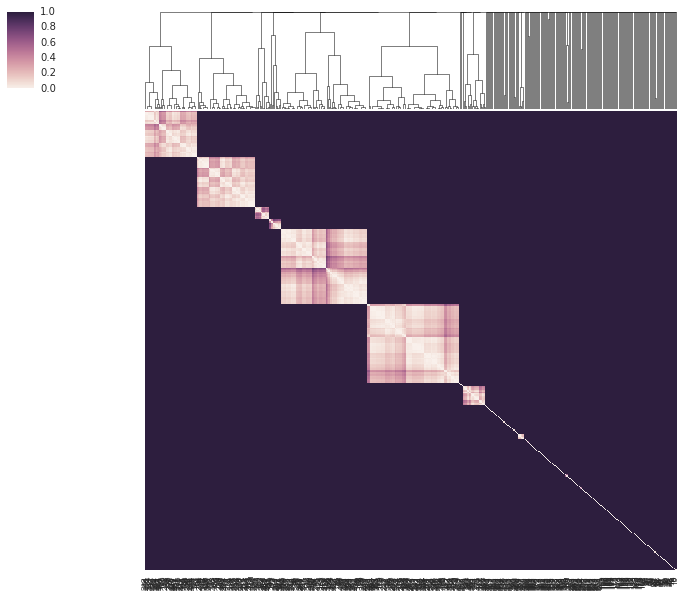

In [339]:
make_distance_matrix_clustergram(my_scan_set.dot_matrix_by_groups[224])